In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import numpy as np

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

C:\Users\witha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question 1: Data Importing

Gold ETF prices

In [2]:
yahoo_financials = YahooFinancials('AAAU')   # AAAU stands for Goldman Sachs Physical Gold ETF
data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-12-31', 
                                                  time_interval='daily')
aaau_df = pd.DataFrame(data['AAAU']['prices'])
aaau_df.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1577975400,15.28,15.20,15.24,15.25,43100,15.25,2020-01-02
1,1578061800,15.49,15.42,15.45,15.45,53400,15.45,2020-01-03
2,1578321000,15.77,15.59,15.76,15.62,84100,15.62,2020-01-06
3,1578407400,15.70,15.64,15.64,15.68,35000,15.68,2020-01-07
4,1578493800,15.75,15.49,15.75,15.56,133600,15.56,2020-01-08


Europe ETF prices

In [3]:
yahoo_financials = YahooFinancials('BBEU')   # BBEU stands for JPMorgan BetaBuilders Europe ETF
data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-12-31', 
                                                  time_interval='daily')
bbeu_df = pd.DataFrame(data['BBEU']['prices'])
bbeu_df.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1577975400,51.639999,51.369999,51.639999,51.619999,166400,48.838078,2020-01-02
1,1578061800,51.259998,50.939999,51.060001,50.980000,114100,48.232571,2020-01-03
2,1578321000,51.200001,50.840000,50.840000,51.200001,165550,48.440716,2020-01-06
3,1578407400,51.160000,50.860001,51.020000,50.919998,197650,48.175808,2020-01-07
4,1578493800,51.180000,50.840000,50.860001,51.060001,177450,48.308262,2020-01-08


Bitcoin prices in USD

In [4]:
yahoo_financials = YahooFinancials('BTC-USD')   # BBEU stands for JPMorgan BetaBuilders Europe ETF
data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-12-31', 
                                                  time_interval='daily')
btc_df = pd.DataFrame(data['BTC-USD']['prices'])
btc_df.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1577836800,7254.330566,7174.944336,7194.892090,7200.174316,18565664997,7200.174316,2020-01-01
1,1577923200,7212.155273,6935.270020,7202.551270,6985.470215,20802083465,6985.470215,2020-01-02
2,1578009600,7413.715332,6914.996094,6984.428711,7344.884277,28111481032,7344.884277,2020-01-03
3,1578096000,7427.385742,7309.514160,7345.375488,7410.656738,18444271275,7410.656738,2020-01-04
4,1578182400,7544.497070,7400.535645,7410.451660,7411.317383,19725074095,7411.317383,2020-01-05


Collating price data in single dataframe

In [5]:
price_data = pd.DataFrame()
price_data = pd.merge(aaau_df[['formatted_date','adjclose']], bbeu_df[['formatted_date','adjclose']], on = 'formatted_date', how = 'left')
price_data = pd.merge(price_data,btc_df[['formatted_date','adjclose']], on='formatted_date', how='left')
price_data.rename(columns={'formatted_date':'Date','adjclose_x':'Gold','adjclose_y':'Equity', 'adjclose':'Bitcoin'}, inplace=True)
price_data = price_data.set_index('Date')
price_data.head()

,Gold,Equity,Bitcoin
Date,,,
2020-01-02,15.25,48.838078,6985.470215
2020-01-03,15.45,48.232571,7344.884277
2020-01-06,15.62,48.440716,7769.219238
2020-01-07,15.68,48.175808,8163.692383
2020-01-08,15.56,48.308262,8079.862793


Price Data after Apr-2020

In [6]:
price_apr = price_data[price_data.index>'2020-03-31']
price_apr.head()

,Gold,Equity,Bitcoin
Date,,,
2020-04-01,15.870000,35.108166,6606.776367
2020-04-02,16.180000,35.624462,6793.624512
2020-04-03,16.180000,34.878696,6733.387207
2020-04-06,16.650000,36.523201,7271.781250
2020-04-07,16.540001,36.790905,7176.414551


# Question 2: Data Processing

In [7]:
rets_apr = price_apr.pct_change()
rets_apr.head()


,Gold,Equity,Bitcoin
Date,,,
2020-04-01,NaN,NaN,NaN
2020-04-02,0.019534,0.014706,0.028281
2020-04-03,0.000000,-0.020934,-0.008867
2020-04-06,0.029048,0.047149,0.079959
2020-04-07,-0.006607,0.007330,-0.013115


# Question 3: Data Summaries

In [8]:
ma_data = price_data.rolling(window=20).mean()
ma_data = ma_data[ma_data.index>'2020-03-31']
ma_data.head()

,Gold,Equity,Bitcoin
Date,,,
2020-04-01,15.8460,35.798507,6642.140503
2020-04-02,15.8205,35.397060,6527.883594
2020-04-03,15.7950,34.990492,6408.425659
2020-04-06,15.7910,34.848748,6375.832495
2020-04-07,15.7980,34.658892,6339.166748


<AxesSubplot:xlabel='Date'>

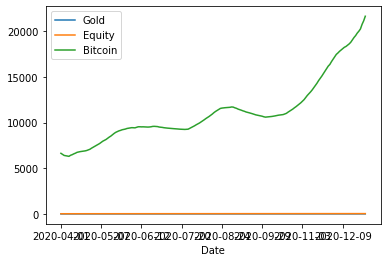

In [9]:
ma_data.plot()

# Question 4: 20-Day Average

In [10]:
def analyze_TS(TS,security):    # TS should be a Series or one column in the DataFrame in pandas
    TS_MA20 = TS.rolling(20).mean()   # calculate moving average for 20 days
    TS.loc[TS.index >= '2020-04'].plot()
    TS_MA20.loc[TS_MA20.index >= '2020-04'].plot()
    plt.title(f"20-day moving average price for {security}")
    plt.xticks(rotation=-45)
    plt.ylabel('Price [%]')
    plt.legend(['daily','MA20'])
    plt.show()
    plt.close()
    
    TS_return = TS.diff()/TS.shift(1)*100   # calculate the return of the portfolio
    plot_acf(TS_return.dropna())
    plt.show()
    plt.close()
    plot_pacf(TS_return.dropna())
    plt.show()
    plt.close()

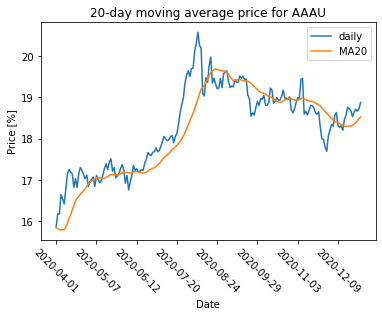

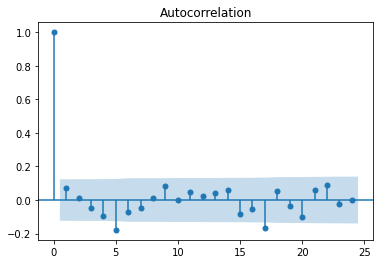

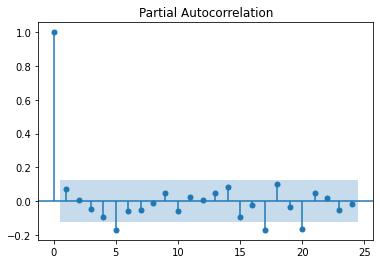

In [11]:
analyze_TS(price_data.Gold,'AAAU')

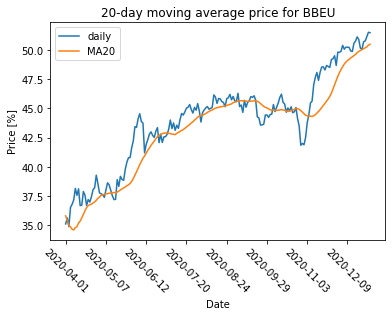

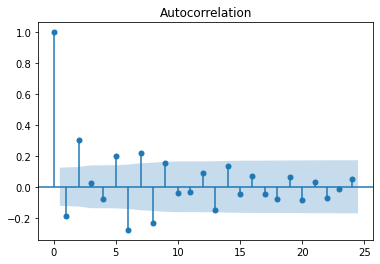

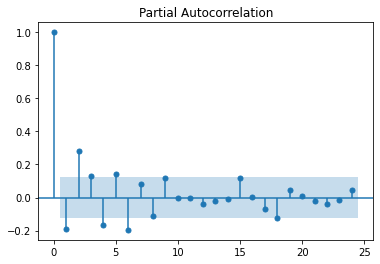

In [12]:
analyze_TS(price_data.Equity,'BBEU')

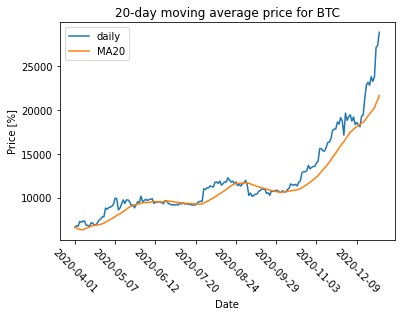

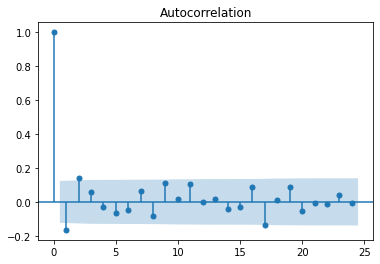

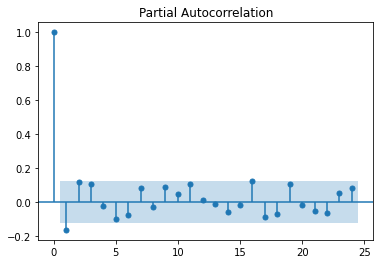

In [13]:
analyze_TS(price_data.Bitcoin,'BTC')

In [14]:
def plot_together(df1, df2, security1, security2):
    fig, ax1 = plt.subplots()
    
    #df = pd.concat([df1, df2], axis=1, join="inner")
    #df.columns = [security1,security2]
    
    #line1 = df[security1].plot(color='C0')
    line1 = df1.loc[df1.index >= '2020-04'].plot(color='C0')
    ax1.set_ylabel(security1, color='C0')
    ax1.tick_params(axis='y', color='C0', labelcolor='C0')
    ax1.spines['left'].set_color('C0')
    
    ax2 = ax1.twinx()
    #line2 = df[security2].plot(color='C1')
    line2 = df2.loc[df2.index >= '2020-04'].plot(color='C1')
    ax2.set_ylabel(security2, color='C1')
    ax2.tick_params(axis='y', color='C1', labelcolor='C1')
    ax2.spines['right'].set_color('C1')

    plt.xticks(rotation=45)
    plt.title(f"Close price for {security1} and {security2}")
    plt.legend([security1,security2])
    plt.show()
    plt.close()

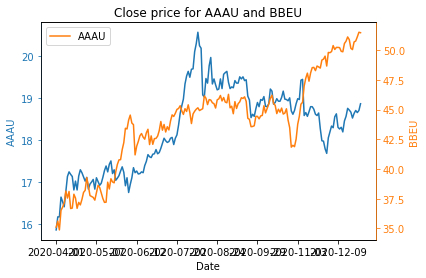

In [15]:
plot_together(price_data.Gold,price_data.Equity, "AAAU", "BBEU")

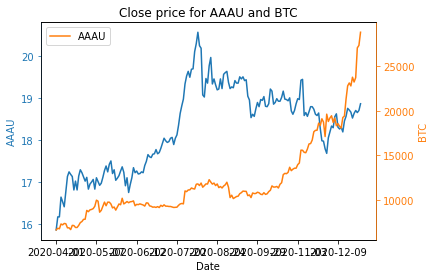

In [16]:
plot_together(price_data.Gold,price_data.Bitcoin, "AAAU", "BTC")

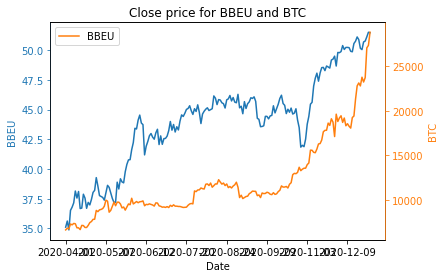

In [17]:
plot_together(price_data.Equity,price_data.Bitcoin, "BBEU", "BTC")

## Question 5: Fitting a GARCH model

The volatility process in a GARCH model is given by

$$\text{Var}(y_t | y_{t-1}) = \sigma^2_t = \omega + \alpha_1 y^2_{t-1} + \beta_1 \sigma_{t-1}^2$$

The value p and q are given by the ACF and PACF plot in Q4

In [18]:
# Garch fitting

def garch_fitting(TS, p, q):

    ETF_return = TS.diff()/TS.shift(1)*100   # calculate the return
    # define model
    model = arch_model(np.array(ETF_return.dropna()), p=p, q=q, mean='Zero')
    # fit model
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    model_fit.plot()

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -88.7529
Distribution:                  Normal   AIC:                           183.506
Method:            Maximum Likelihood   BIC:                           189.887
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       59
Time:                        08:44:26   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0000  4.395e-02      0.000      1.000 

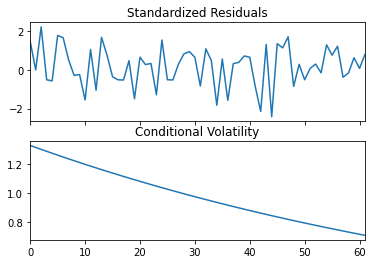

In [19]:
# AAAU Garch fitting for Q2
garch_fitting(price_data.loc['2020-04':'2020-07'].Gold, 1, 1)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -101.937
Distribution:                  Normal   AIC:                           209.875
Method:            Maximum Likelihood   BIC:                           216.304
                                        No. Observations:                   63
Date:                Sun, Jan 23 2022   Df Residuals:                       60
Time:                        08:44:27   Df Model:                            3
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1842      0.142      1.294      0.196 [-9.47

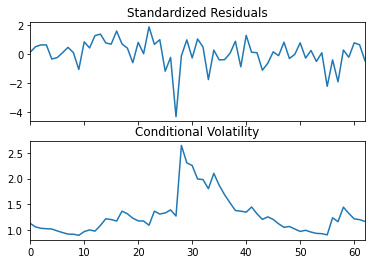

In [20]:
# AAAU Garch fitting for Q3
garch_fitting(price_data.loc['2020-07':'2020-10'].Gold, 1, 1)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.016
Vol Model:                      GARCH   Log-Likelihood:               -89.8964
Distribution:                  Normal   AIC:                           185.793
Method:            Maximum Likelihood   BIC:                           192.174
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       59
Time:                        08:44:28   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1065  6.326e-02      1.684  9.225e-02 

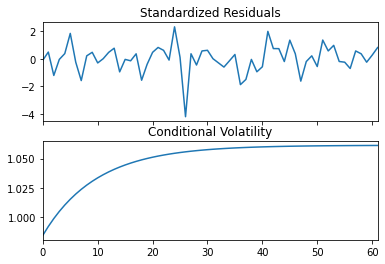

In [21]:
# AAAU Garch fitting for Q4
garch_fitting(price_data.loc['2020-10':'2021-01'].Gold, 1, 1)

In [22]:
# Garch-M fitting

def m_garch_fitting(TS, p, q):

    ETF_return = TS.diff()/TS.shift(1)*100   # calculate the return
    # define model
    model = arch_model(np.array(ETF_return.dropna()), p=p, q=q)
    # fit model
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    model_fit.plot()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -171.273
Distribution:                  Normal   AIC:                           350.546
Method:            Maximum Likelihood   BIC:                           359.054
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       58
Time:                        08:44:31   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4973      0.898      0.554      0.580 [ -1.262,  2.25

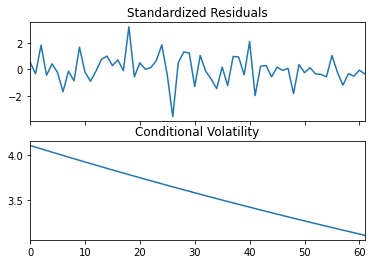

In [23]:
# BTC Garch-M fitting for Q2
m_garch_fitting(price_data.loc['2020-04':'2020-07'].Bitcoin, 1, 1)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -159.630
Distribution:                  Normal   AIC:                           327.259
Method:            Maximum Likelihood   BIC:                           335.832
                                        No. Observations:                   63
Date:                Sun, Jan 23 2022   Df Residuals:                       59
Time:                        08:44:32   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2957      0.382      0.775      0.438 [ -0.452,  1.04

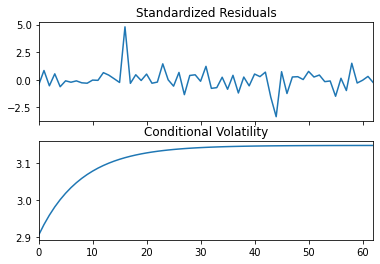

In [24]:
# BTC Garch-M fitting for Q3
m_garch_fitting(price_data.loc['2020-07':'2020-10'].Bitcoin, 1, 1)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -170.057
Distribution:                  Normal   AIC:                           348.114
Method:            Maximum Likelihood   BIC:                           356.623
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       58
Time:                        08:44:33   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.5495      0.439      3.531  4.142e-04 [  0.689,  2.41

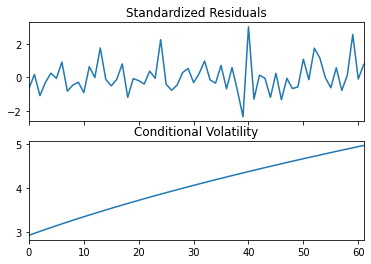

In [25]:
# BTC Garch-M fitting for Q4
m_garch_fitting(price_data.loc['2020-10':'2021-01'].Bitcoin, 1, 1)

### Fitting a T-GARCH model

The volatility process in a T-GARCH model is given by
$$ \sigma_t = \omega + \alpha|\epsilon_{t−1}| + \gamma∣\epsilon_{t−1}∣𝐼_{[\epsilon_t−1<0]}+ \beta \sigma_{t−1} $$

The value p and q are given by the ACF and PACF plot in Q4

In [26]:
# Garch fitting

def t_garch_fitting(TS, p, q):

    ETF_return = TS.diff()/TS.shift(1)*100   # calculate the return
    # define model
    model = arch_model(np.array(ETF_return.dropna()), p=p, q=q, power=1.0)
    # fit model
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    model_fit.plot()

                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                    AVGARCH   Log-Likelihood:               -126.250
Distribution:                  Normal   AIC:                           260.499
Method:            Maximum Likelihood   BIC:                           269.008
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       58
Time:                        08:44:40   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3293      0.347      0.950      0.342 [ -0.350,  1.00

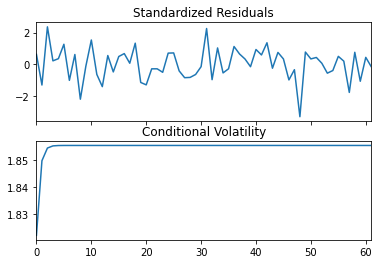

In [27]:
# BBEU T-Garch fitting for Q2
t_garch_fitting(price_data.loc['2020-04':'2020-07'].Equity, 1, 1)

                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                    AVGARCH   Log-Likelihood:               -96.9796
Distribution:                  Normal   AIC:                           201.959
Method:            Maximum Likelihood   BIC:                           210.532
                                        No. Observations:                   63
Date:                Sun, Jan 23 2022   Df Residuals:                       59
Time:                        08:44:41   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0806      0.126      0.637      0.524 [ -0.167,  0.32

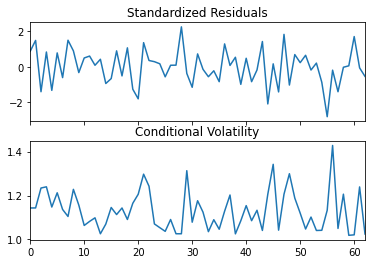

In [28]:
# BBEU T-Garch fitting for Q3
t_garch_fitting(price_data.loc['2020-07':'2020-10'].Equity, 1, 1)

                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:                      y   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                    AVGARCH   Log-Likelihood:               -97.7072
Distribution:                  Normal   AIC:                           203.414
Method:            Maximum Likelihood   BIC:                           211.923
                                        No. Observations:                   62
Date:                Sun, Jan 23 2022   Df Residuals:                       58
Time:                        08:44:43   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1941  4.850e-04    400.170      0.000 [  0.193,  0.19

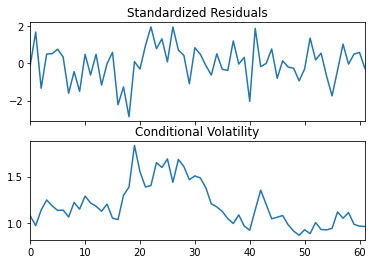

In [29]:
# BBEU T-Garch fitting for Q4
t_garch_fitting(price_data.loc['2020-10':'2021-01'].Equity, 1, 1)

# Question 6: Assessing stationarity

### The Augmented Dickey-Fuller test

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [30]:
def adf_test(TS):
    ETF_return = TS.diff()/TS.shift(1)*100   # calculate the return
    result = adfuller(ETF_return.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [31]:
# ADF test for AAAU in Q4
adf_test(price_data.loc['2020-10':'2021-01'].Gold)

ADF Statistic: -7.369050
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


#### AAAU return is stationary
- p-value<0.05 and Null Hypothesis (H0) is rejected.  

In [32]:
# ADF test for BBEU in Q4
adf_test(price_data.loc['2020-10':'2021-01'].Equity)

ADF Statistic: -3.899004
p-value: 0.002042
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593


#### BBEU return is stationary
- p-value<0.05 and Null Hypothesis (H0) is rejected.  

In [33]:
# ADF test for BTC in Q4
adf_test(price_data.loc['2020-10':'2021-01'].Bitcoin)

ADF Statistic: -9.776427
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


#### BTC return is stationary
- p-value<0.05 and Null Hypothesis (H0) is rejected.  

# Question 7: Modelling Cointegration


In [41]:
from statsmodels.tsa.tsatools import lagmat

Gold and Equity Data Conintegration Using Engle Granger Test

In [50]:
import pandas as pd
df = pd.DataFrame(ma_data, columns= ['Gold','Equity'])
X = df["Gold"]
y = df["Equity"]
from statsmodels.tsa.stattools import coint
print('Results of Engle-Granger Test:')
egtest = coint(y, X, trend='c', method='aeg', autolag='AIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Results of Engle-Granger Test:
Test Statistic                                                        -1.89683
p-value                                                               0.581614
Critical Values 1%,5%,10%    [-3.9553251403936063, -3.36864957951905, -3.06...
dtype: object


In [51]:
import pandas as pd
df = pd.DataFrame(ma_data, columns= ['Gold','Bitcoin'])
X = df["Gold"]
y = df["Bitcoin"]
from statsmodels.tsa.stattools import coint
print('Results of Engle-Granger Test:')
egtest = coint(y, X, trend='c', method='aeg', autolag='AIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Results of Engle-Granger Test:
Test Statistic                                                         1.38042
p-value                                                                      1
Critical Values 1%,5%,10%    [-3.9553251403936063, -3.36864957951905, -3.06...
dtype: object


In [52]:
import pandas as pd
df = pd.DataFrame(ma_data, columns= ['Equity','Bitcoin'])
X = df["Equity"]
y = df["Bitcoin"]
from statsmodels.tsa.stattools import coint
print('Results of Engle-Granger Test:')
egtest = coint(y, X, trend='c', method='aeg', autolag='AIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Results of Engle-Granger Test:
Test Statistic                                                        0.544216
p-value                                                               0.992922
Critical Values 1%,5%,10%    [-3.9553251403936063, -3.36864957951905, -3.06...
dtype: object


Bitcoin and Equity Data Conintegration Using Johansen Test

In [83]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
x = pd.DataFrame(ma_data, columns= ['Equity','Bitcoin']) # dataframe of n series for cointegration analysis
jres1 = coint_johansen(x, det_order=0, k_ar_diff=1)

In [84]:
jres1.cvm

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

Gold and Equity Data Conintegration Using Johansen Test

In [85]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
y = pd.DataFrame(ma_data, columns= ['Gold','Bitcoin']) # dataframe of n series for cointegration analysis
jres2 = coint_johansen(y, det_order=0, k_ar_diff=1)

In [86]:
jres2.cvm

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [89]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
z = pd.DataFrame(ma_data, columns= ['Gold','Equity']) # dataframe of n series for cointegration analysis
jres3 = coint_johansen(z, det_order=0, k_ar_diff=1)

In [91]:
jres3.cvm

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

7)Explain if Johansen test and Engle-Granger provided different results. 


Both, Engle-Granger and Johansen tests provide similar results that the p value is more than the threshold value of 0.05 and thus we cannot reject the null hypothesis that the trends are not cointegrated.

7)Implement a VEC model and forecast Q4 evolution. Comment results. (Provide arguments if VEC can not be used).

The given series are stationary and the we cannot reject the null hypothesis that the series are not cointegrated. VEC are designed to be used with series that are known to be cointegrated and non-stationary. Thus for the given series we cannot implement VEC model to forecast the Q4 evolution

7)Implement a VAR model and forecast Q4 evolution. Comment results. 


In [152]:
X_train, X_test = ma_data[0:-90],ma_data[-90:]

In [153]:
X_train_log = np.log(X_train)
X_train_log_diff =(X_train_log).diff().dropna()
X_train_log_diff.describe()

,Gold,Equity,Bitcoin
count,99.000000,99.000000,99.000000
mean,0.002189,0.002354,0.005585
std,0.002151,0.003292,0.007363
min,-0.001613,-0.011552,-0.018469
25%,0.000568,0.000863,-0.000828
50%,0.001831,0.002180,0.006023
75%,0.003457,0.004187,0.011393
max,0.006901,0.008969,0.018304


In [154]:
from statsmodels.tsa.api import VAR

In [155]:
#Initiate VAR model
model = VAR(endog=X_train_log_diff)
res = model.select_order(5)
res.summary()

C:\Users\witha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-34.58,-34.49,9.641e-16,-34.54
1,-38.67,-38.35*,1.602e-17,-38.54
2,-38.86,-38.29,1.332e-17,-38.63*
3,-38.90,-38.09,1.280e-17,-38.57
4,-39.00,-37.94,1.161e-17,-38.57
5,-39.13*,-37.83,1.027e-17*,-38.60


In [156]:
#Fit to a VAR model
model_fit = model.fit(maxlags=2)
#Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Jan, 2022
Time:                     13:19:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -38.2885
Nobs:                     97.0000    HQIC:                  -38.6205
Log likelihood:           1492.12    FPE:                1.34823e-17
AIC:                     -38.8459    Det(Omega_mle):     1.09390e-17
--------------------------------------------------------------------
Results for equation Gold
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000421         0.000156            2.696           0.007
L1.Gold            0.824691         0.114447            7.206           0.000
L1.Equity         -0.063212         0.070681           -0.894           0

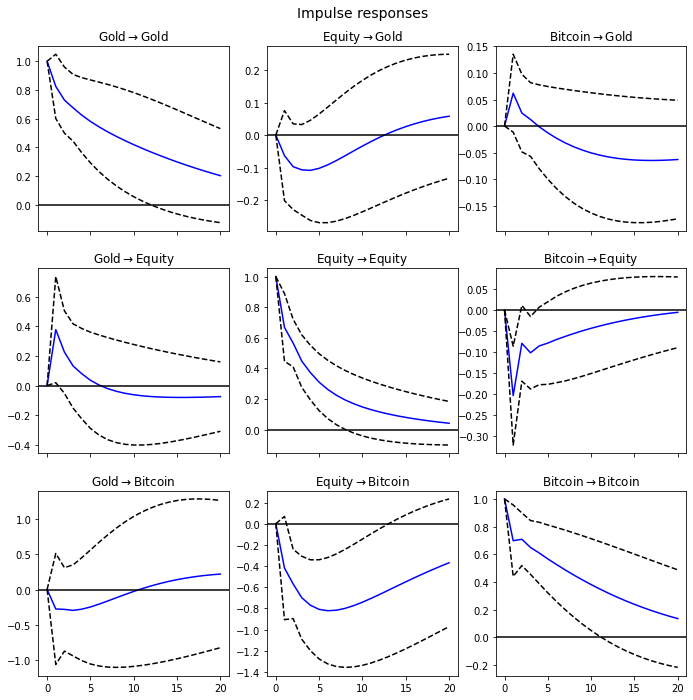

In [191]:
# Impulse Response Analysis
irf = model_fit.irf(20)
irf.plot()
plt.show()

In [157]:
# Input data for forecasting
input_data = X_train_log_diff.values[-10:]
print(input_data)
# forecasting
pred = model_fit.forecast(y=input_data, steps=90)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

[[0.00580076 0.00190916 0.01269762]
 [0.00267996 0.00115659 0.01032636]
 [0.00249137 0.00177512 0.01127493]
 [0.0040611  0.00170798 0.01235272]
 [0.00337599 0.00081027 0.01204452]
 [0.00421043 0.0009161  0.0140354 ]
 [0.00411623 0.0007876  0.01173122]
 [0.0017844  0.00027658 0.0099043 ]
 [0.00162866 0.00065922 0.01008851]
 [0.00086415 0.00059505 0.0089416 ]]
            Gold_pred  Equity_pred  Bitcoin_pred
Date                                            
2020-08-24   0.000977     0.001127      0.010012
2020-08-25   0.001128     0.001403      0.010103
2020-08-26   0.001174     0.001800      0.010199
2020-08-27   0.001205     0.002036      0.010142
2020-08-28   0.001218     0.002238      0.010018
...               ...          ...           ...
2020-12-23   0.001947     0.003095      0.006288
2020-12-24   0.001947     0.003094      0.006290
2020-12-28   0.001946     0.003094      0.006291
2020-12-29   0.001946     0.003094      0.006292
2020-12-30   0.001945     0.003094      0.006293

[

In [158]:
forecast = pred.copy()

In [159]:
# inverting transformation
def invert_transformation(X_train, pred_df):
    forecast = pred.copy()
    columns = X_train.columns
    for col in  X_train.columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col) +'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, pred)
print(output)


            Gold_pred  Equity_pred  Bitcoin_pred
Date                                            
2020-08-24  19.681977    45.196767  11546.045754
2020-08-25  19.683105    45.198170  11546.055857
2020-08-26  19.684279    45.199970  11546.066056
2020-08-27  19.685484    45.202005  11546.076198
2020-08-28  19.686702    45.204243  11546.086216
...               ...          ...           ...
2020-12-23  19.824642    45.454104  11546.622459
2020-12-24  19.826589    45.457199  11546.628748
2020-12-28  19.828535    45.460293  11546.635039
2020-12-29  19.830480    45.463387  11546.641331
2020-12-30  19.832426    45.466482  11546.647625

[90 rows x 3 columns]


# Question 8) Correlation vs Cointegration

8) Does correlation have a direction?  In other words, is the correlation of x and y equal to correlation of y and x?


No, correlation does not have a direction. Correlation simplay implies how do two factors change with change in each other. As shown below, If we look at the Pearson correlation between 2 series, first looking at the correlation of Gold vs Equity and then Equity vs Gold, we see that the pearson coefficient is same for both the correlations irrespective of their direction.

In [162]:
import numpy as np
import scipy.stats

In [163]:
scipy.stats.pearsonr(ma_data['Gold'],ma_data['Equity'])

(0.8051958424723666, 1.5583688064533298e-44)

In [164]:
scipy.stats.pearsonr(ma_data['Equity'],ma_data['Gold'])

(0.8051958424723666, 1.5583688064533298e-44)

8) Does linear regression have a direction?  Are the slope and intercept the same if x is regressed on y, or y is regressed on x?


Yes, linear regression has a direction because linear regression model shows the relationship between factors. The equation shows how much does changing 1 variable change the other variable. As this relationship depends on the size of the individual factors itself, thus the linear regression model have a direction. As can be seen by showing the relationship between Gold and Equity return values. The regression of Gold by Equity and Equity by Gold does not produce the same equation and hence does not give the same model variables.

In [165]:
from sklearn.linear_model import LinearRegression

In [172]:
xr = np.array(ma_data['Gold']).reshape((-1, 1))

In [173]:
yr=np.array(ma_data['Equity'])

In [174]:
model = LinearRegression().fit(xr,yr)

In [175]:
model.coef_

array([2.99383599])

In [176]:
model.intercept_

-11.163770655533419

In [177]:
xr1=np.array(ma_data['Equity']).reshape((-1, 1))

In [178]:
yr1=np.array(ma_data['Gold'])

In [179]:
model2 = LinearRegression().fit(xr1,yr1)

In [180]:
model2.coef_

array([0.2165584])

In [181]:
model2.intercept_

8.800305126818259

8)Does cointegration have a direction?  Will the cointegrating vector be the same if x is regressed on y, or if y is regressed on x?


By definition, Cointegration implies that the combination of 2 series is stationary thus Cointegration does not have a direction. As shown by the cointegration test of Gold and Equity, we see that the test values for both the series is same.

In [182]:
import pandas as pd
df = pd.DataFrame(ma_data, columns= ['Gold','Equity'])
X1 = df["Gold"]
y1 = df["Equity"]
from statsmodels.tsa.stattools import coint
print('Results of Engle-Granger Test:')
egtest = coint(y1, X1, trend='c', method='aeg', autolag='AIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Results of Engle-Granger Test:
Test Statistic                                                        -1.89683
p-value                                                               0.581614
Critical Values 1%,5%,10%    [-3.9553251403936063, -3.36864957951905, -3.06...
dtype: object


In [183]:
import pandas as pd
df = pd.DataFrame(ma_data, columns= ['Gold','Equity'])
X1 = df["Gold"]
y1 = df["Equity"]
from statsmodels.tsa.stattools import coint
print('Results of Engle-Granger Test:')
egtest = coint(X1, y1, trend='c', method='aeg', autolag='AIC')
egoutput = pd.Series(egtest[0:3], index=['Test Statistic','p-value','Critical Values 1%,5%,10%'])
print (egoutput)

Results of Engle-Granger Test:
Test Statistic                                                        -3.12239
p-value                                                              0.0838938
Critical Values 1%,5%,10%    [-3.9553251403936063, -3.36864957951905, -3.06...
dtype: object


# Question 9 Discussion


"As an Alternative Investments (gold and/or bitcoin) portfolio manager, write a TECHNICAL 1-page report about your findings during the investment year of COVID.   

Complete answers contain 3 parts: summary of key results; their interpretation; and the recommended course of action that can reasonably follow from those results and interpretations.  
Possible courses of action include trading, hedging, re-allocating, etc.  
Technical reports will include the technicalities of models, such as names, methods of estimation, parameter values, etc. and exclude generalities about the work done.  It should NOT include the names of Python or R code that was used."


In [190]:
ma_data.pct_change()

,Gold,Equity,Bitcoin
Date,,,
2020-04-01,NaN,NaN,NaN
2020-04-02,-0.001609,-0.011214,-0.017202
2020-04-03,-0.001612,-0.011486,-0.018300
2020-04-06,-0.000253,-0.004051,-0.005086
2020-04-07,0.000443,-0.005448,-0.005751
...,...,...,...
2020-12-23,0.001774,0.001520,0.010449
2020-12-24,0.001989,0.001519,0.012517
2020-12-28,0.002339,0.001615,0.024648


Investment year of COVID has seen a lot of volatility in all the alternative investments due to sudden shock of the COVID insurgence and then the subsequent resurgence and decline resurgence cycle. However, after the initial shock we have seen that the markets stabilized for all the investments and further on we saw that some investments were more resilient and stable in the long term. The GARCH model when fitted on the return prices for the COVID period for all the 3 alternate portfolios of Gold, Equity and Bitcoin shows that the return prices trends were stationary. The Conditional Volatility for the T Garch model for the Gold portfolio for Q2, Q3, Q4 shows alternating trends starting with the downward sloping trend, followed by the random trend and parabolic upward trend. Similaryl for Bitcoin also, we see a random trend in the Q2 while an exponential rise in the Q3 followed by a linear rise in Q4. comparing these outputs of the TGARCH model for Gold and Bitcoin and Equity return we can clearly see that Bitcoin has proved to be more resilient and returing. 
Looking at the daily return trend we see that all the 3 alternate investment products, Gold, Equity and Bitcoin show a decline at the start of the COVID, Equity shows and average daily decline of 1.2% while Gold seems more resilient and stable showing a 0.1% decline, however with Bitcoin we see that the decline is more or less in line with Equity showing 1.7 to 1.8% decline. 
But once the pandemic and the shock caused by it stabilizes, we see Bitcoin rises by 2.37% on average compared to 0.21% growth shown by Gold and 0.16% growth shown by Equity. This shows that Bitcoin has been more resilient as a long term portfolio strategy during the COVID time period. 
Given the still evolving nature of Bitcoin and the Government regulations around it followed by its mass adaptation we have seen pretty high volatility but long term significant rise in the portfolio of Bitcoin compared to other Alternate portfolio investments. Based on this we do recommend to include Bitcoin as a long term alternate investment strategy.

"As Alternative Investments (gold and/or bitcoin) portfolio manager, write a NON-TECHNICAL paragraph or two to your client base explaining your performance relative to equity investments.  

Complete answers contain 3 parts: 1) clear explanation of results; 2) the recommended course of action that follows; 3) identify factors that impact each portfolio.
This time, however, the intended audience is non-technical, so AVOID all references to model names, algorithms, unnecessary details, and focus on the investment decision. "


Bitcoin has been one of the most resilient investments during the COVID time period, though there has been very strong variance in the price from a day to day price. Just like other investment such as Equity, Bitcoin suffered immensely at the begining of the pandemic but went on to outperform itself during the next 6 months following the crash. From around $7,000 on January 1, 2020 to around $17,000 on November 27, 2020, bitcoin has surged during the Covid-19 pandemic. The stock markets have also been very shaky. People know that stock market conditions depend on companies which have, again, been affected by the pandemic. COVID has shown that Bitcoin is more or less conserved like gold and just like Gold gives a great return for a long term investment. In bitcoin, as the digital currency is still not heavily regulated, there is still a lot of confusion in the market, however, investing in Bitcoin as of now and holding the asset for a long time period will give great returns compared to equity return. Bitcoin can be a great asset for expanding the portfolio. We would recommend that the investors start with a small investment in the Bitcoin as still there is a lot of confusion around the regulations and the market. As can be seen from the last few months of data, Bitcoin prices significantly depend on the market sentiments and government regulation. Unlike Equity, which depend on company's and stocks performance (an easily accessible data), Bitcoins are still heavily dependent on the market regulations and availability. As the Bitcoins are limited (they have to be mined), the prices heavily follow the demand supply constraint. As more and more bitcoins are getting mined, the supply is going to be exhausted in some time and thus the prices keep fluctuating. It's recommended to include Bitcoin as an option to diversify your long term portfolio.

Write a 1-page report that specifically explains how your group divided the work with details.


The idea behind the work division in the group was based on the simple strategy that every team member gets an opportunity to get hands on experience by doing the work. Even if a particular skill might not be your best skill, but still by working on the problem and trying to solve it, you get an opportunity to enhance and grow that skill. Based on this simple strategy, we created a rotational roster. Our team has 3 individulas and each of the assignments have 9 questions which gives 3 quesionts per individual per assignment. We created a roster like this: 

Person	Project I	Project II	Project III	
1	     Q1-Q3	      Q4-Q6  	 Q7-Q9	
2	     Q7-Q9	      Q1-Q3	     Q4-Q6		 
3	     Q4-Q6	      Q7-Q9	     Q1-Q3	

This way every individual got an opporunity to work on the problem sets and assignment in totaltity. However, after every assignment, the team members cross checked the other individuals work to ensure that the work was accurate and upto the mark. This helped in sharing of ideas and improvement of the overall work. This was we got to know about others perspective and point of view and also got an oppotunity to learn new things.